# Slithering Snake Example

This Elastica tutorial explains how to setup a Cosserat rod simulation to simulate a slithering snake. It is a more complex use case than the Timoshenko Beam example. If you have not done so, we strongly suggest you start with [this beam example](./1_Timoshenko_Beam.ipynb) as it covers many of the basics of setting up and running simulations with Elastica. 

This slithering snake example includes gravitational forces, friction forces, and internal muscle torques. It also introduces the use of call back functions to allow logging of simulations data for post-processing after the simulation is over. 


## Getting Started
To set up the simulation, the first thing you need to do is import the necessary classes. As with the Timoshenko bean, we need to import wrapper functions which allow us to more easily construct different simulation systems. We also need to import a rod class, all the necessary forces to be applied, timestepping functions, and callback classes. 

In [18]:
import numpy as np

# import wrappers
from elastica.wrappers import BaseSystemCollection, Constraints, Forcing, CallBacks

# import rod class and forces to be applied
from elastica.rod.cosserat_rod import CosseratRod
from elastica.external_forces import GravityForces, MuscleTorques
from elastica.interaction import AnisotropicFrictionalPlane

# import timestepping functions
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

# import call back functions
from elastica.callback_functions import CallBackBaseClass
from collections import defaultdict

## Initialize System and Add Rod
The first thing to do is initialize the simulator class by combining all the imported wrappers. After initializing, we will generate a rod and add it to the simulation. 

In [19]:
class SnakeSimulator(BaseSystemCollection, Constraints, Forcing, CallBacks):
    pass
snake_sim = SnakeSimulator()

# Define rod parameters
n_elem = 50
start = np.array([0.0, 0.0, 0.0])
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
base_length = 1.0
base_radius = 0.025
base_area = np.pi * base_radius ** 2
density = 1000
nu = 5.0
E = 1e7
poisson_ratio = 0.5

# Create rod
shearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)

# Add rod to the snake system
snake_sim.append(shearable_rod)

## Add Forces to Rod
With our rod added to the system, we need to specify the relevant forces that will be acting on the rod. For all the forces, the method of adding forces is `system_name.add_forcing_to(name_of_rod).using(type_of_force, *kwargs)` where `*kwargs` are the parameters specific to each type of force. 

### Gravity
The first force to add is gravity. We specify the strength of gravity and also the direction it is pointing. 

In [20]:
# Add gravitational forces
gravitational_acc = -9.80665
snake_sim.add_forcing_to(shearable_rod).using(
    GravityForces, acc_gravity=np.array([0.0, gravitational_acc, 0.0])
)
print('Gravity now acting on shearable rod')

Gravity now acting on shearable rod


### Muscle Torques
A snake generates torque throughout its body through muscle activations. While these muscle activations are generated internally by the snake, it is simpler to treat them as applied external forces, allowing us to apply them to the rod in the same manner as the other external forces. 

You may notice that the muscle torque parameters appear to have special values. These are optimized coefficients for a snake gait. For information about how to do this optimization, see the [snake optimization example script](../ContinuumSnakeCase/continuum_snake.py).

In [21]:
# Define muscle torque parameters
period = 1.0
wave_length = 0.97
b_coeff=np.array([17.4, 48.5, 5.4, 14.7])

# Add muscle torques to the rod
snake_sim.add_forcing_to(shearable_rod).using(
    MuscleTorques,
    base_length=base_length,
    b_coeff=b_coeff,
    period=period,
    wave_number=2.0 * np.pi / (wave_length),
    phase_shift=0.0,
    ramp_up_time=period,
    direction=normal,
    with_spline=True,
)
print('Muscle torques added to the rod')

Muscle torques added to the rod


### Anisotropic Friction Forces
The last force that needs to be added is the friction force between the snake and the ground. Snakes exhibits anisotropic friction where the friction coefficient is different in different directions. You can also define both static and kinematic friction coefficients. This is accomplished by defining some small velocity threshold `slip_velocity_tol` that defines the transitions between static and kinematic friction. 

In [34]:
# Define friction force parameters
origin_plane = np.array([0.0, -base_radius, 0.0])
normal_plane = normal
slip_velocity_tol = 1e-8
froude = 0.1
mu = base_length / (period * period * np.abs(gravitational_acc) * froude)
kinetic_mu_array = np.array([1.0 * mu, 1.5 * mu, 2.0 * mu])  # [forward, backward, sideways]
static_mu_array = 2 * kinetic_mu_array

# Add friction forces to the rod
snake_sim.add_forcing_to(shearable_rod).using(
    AnisotropicFrictionalPlane,
    k=1.0,
    nu=1e-6,
    plane_origin=origin_plane,
    plane_normal=normal_plane,
    slip_velocity_tol=slip_velocity_tol,
    static_mu_array=static_mu_array,
    kinetic_mu_array=kinetic_mu_array,
)
print('Friction forces added to the rod')

Friction forces added to the rod


## Add Callback Function
The simulation is now setup, but before it is run, we want to define a callback function. A callback function allows us to record time-series data throughout the simulation. If you do not define a callback function, you will only have access to the final configuration of the system. If you want to be able to analyze how the system evolves over time, it is critical that you record the appropriate quantities. 

To create a callback function, begin with the `CallBackBaseClass`. You can then define which state quantities you wish to record by having them appended to the `self.callback_params` dictionary as well as how often you wish to save the data by defining `skip_step`.

In [35]:
# Add call backs
class ContinuumSnakeCallBack(CallBackBaseClass):
    """
    Call back function for continuum snake
    """

    def __init__(self, step_skip: int, callback_params: dict):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):

        if current_step % self.every == 0:

            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(
                system.position_collection.copy()
            )
            self.callback_params["velocity"].append(
                system.velocity_collection.copy()
            )
            self.callback_params["avg_velocity"].append(
                system.compute_velocity_center_of_mass()
            )

            self.callback_params["center_of_mass"].append(
                system.compute_position_center_of_mass()
            )

            return

pp_list = defaultdict(list)
snake_sim.collect_diagnostics(shearable_rod).using(
    ContinuumSnakeCallBack, step_skip=200, callback_params=pp_list
)
print('Callback function added to the simulator')

Callback function added to the simulator


With the callback function added, we can now finalize the system and also define the time stepping parameters of the simulation such as the time step, final time, and time stepping algorithm to use. 

In [24]:
snake_sim.finalize()

final_time = 5.0 * period
dt = 4.0e-5
total_steps = int(final_time / dt)
print("Total steps", total_steps)

timestepper = PositionVerlet()

Now all that is left is to run the simulation. Using the default parameters the simulation takes about 2-3 minutes to complete. 

In [26]:
integrate(timestepper, snake_sim, final_time, total_steps)

100%|██████████| 124999/124999 [02:05<00:00, 998.35it/s] 

Final time of simulation is :  5.0000000000050635


## Post-Process Data
With the simulation complete, we want to analyze the simulation. Because we added a callback function, we can analyze how the snake evolves over time. All of the data from the callback function is located in the `pp_list` dictionary. Here we will use this information to compute and plot the velocity of the snake in the forward, lateral, and normal directions. We do this by using a pre-written analysis function `compute_projected_velocity`.

In the plotted graph, you can see that it takes about one period for the snake to begin moving before rapidly reaching a steady gait over just 2-3 periods. We also see that the normal velocity is zero since we are only actuating the snake in a 2D plane. 

average forward velocity: 0.5497085469875231
average forward lateral: -0.013494761555933437


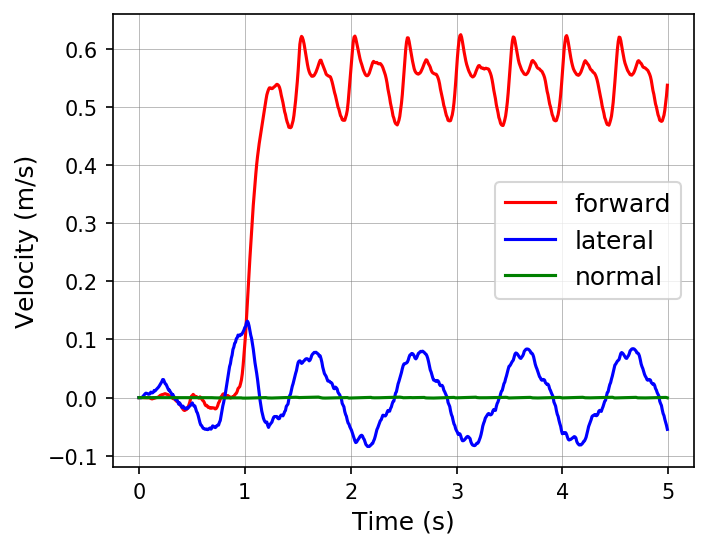

In [27]:
def compute_and_plot_velocity(plot_params: dict, period):
    from matplotlib import pyplot as plt
    from analysis_functions import compute_projected_velocity

    time_per_period = np.array(plot_params["time"]) / period
    avg_velocity = np.array(plot_params["avg_velocity"])

    [velocity_in_direction_of_rod, 
     velocity_in_rod_roll_dir, 
     avg_forward, 
     avg_lateral] = compute_projected_velocity(plot_params, period)
    
    print("average forward velocity:", avg_forward)
    print("average forward lateral:", avg_lateral)

    fig = plt.figure(figsize=(5,4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    ax.grid(b=True, which="major", color="grey", linestyle="-", linewidth = 0.25)
    ax.plot(time_per_period[:], velocity_in_direction_of_rod[:, 2], "r-", label="forward")
    ax.plot(time_per_period[:], velocity_in_rod_roll_dir[:, 0], "b-", label="lateral",)
    ax.plot(time_per_period[:], avg_velocity[:, 1], "g-", label="normal")
    ax.legend(prop={"size": 12})
    ax.set_ylabel('Velocity (m/s)', fontsize = 12)
    ax.set_xlabel('Time (s)', fontsize = 12)
    plt.show()

compute_and_plot_velocity(pp_list, period)

### Make Video of Snake Gait
Because we saved data of the snake's behavior, we can make a video of its movement. The easiest way to do this is to do this is to plot the snake's position at each time that the data was recorded and then stitch these plots together to form a video. 

note: ffmpeg is required for matplotlib to be able to create a video. More info on ffmepg [here](https://www.ffmpeg.org/).

In [31]:
from IPython.display import Video

def plot_video( plot_params: dict, video_name="video.mp4", margin=0.2, fps=15):  
    from matplotlib import pyplot as plt
    import matplotlib.animation as manimation

    positions_over_time = np.array(plot_params["position"])

    print("creating video -- this can take a few minutes")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure()
    plt.axis("equal")
    with writer.saving(fig, video_name, dpi=100):
        for time in range(1, len(plot_params["time"])):
            x = positions_over_time[time][2]
            y = positions_over_time[time][0]
            fig.clf()
            plt.plot(x, y, "-", linewidth=3)
            plt.xlim([0 - margin, 3 + margin])
            plt.ylim([-1.5 - margin, 1.5 + margin])
            writer.grab_frame()
    plt.close(fig)

filename_video = "continuum_snake.mp4"
plot_video(pp_list, video_name=filename_video, margin=0.2, fps=125)
    
Video("continuum_snake.mp4")

creating video -- this can take a few minutes


Finally, you can also plot the position of the snake from a 3D perspective. This is most helpful is you have a simulation that consists of more than planar motion. 

In [33]:
from IPython.display import Video

def plot_video( plot_params: dict, video_name="video.mp4", margin=0.2, fps=15):  
    from matplotlib import pyplot as plt
    import matplotlib.animation as manimation
    from mpl_toolkits import mplot3d
    
    positions_over_time = np.array(plot_params["position"])
    print("creating video -- this can take a few minutes")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure()
    with writer.saving(fig, video_name, dpi=100):
        for time in range(1, len(plot_params["time"])): 
            x = positions_over_time[time][0]
            y = positions_over_time[time][2]
            z = positions_over_time[time][1]
            
            fig.clf()
            ax = fig.add_subplot( 111, projection="3d" )
            plt.plot(y, x,z, "-", linewidth=3)
            ax.set_xlim(0 - margin, 3 + margin)
            ax.set_ylim(-1.5 - margin, 1.5 + margin)
            ax.set_zlim(0, 1)
        
            ax.view_init(elev=20, azim=-80)
            writer.grab_frame()
    plt.close(fig)
filename_video = "continuum_snake_3d.mp4"
plot_video(pp_list, video_name=filename_video, margin=0.2, fps=125)
    
Video("continuum_snake_3d.mp4")

creating video -- this can take a few minutes
